In [141]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge



import matplotlib.pyplot as plt

import math
import time
from sklearn.model_selection import KFold

In [107]:
combined = pd.read_csv('../data/all-agg.csv')
feats = ['YEAR', 'GSP', 'GDD', 'GSTmax', 'GSTmin', 'frost', 'summer' ,'HWI', 'CWI', 'dry' ,'wet', 'PRCP95P']
X = combined[feats]
y = combined['corn']
combined

,YEAR,GSP,GDD,GSTmin,GSTmax,frost,summer,HWI,CWI,dry,wet,PRCP95P,corn,beans
0,-1.697676,0.648504,1.571329,1.675750,1.247613,-1.079558,0.660203,0.681205,-0.551278,-0.577854,-0.253058,1.030478,-1.397146,-1.611652
1,-1.651793,0.074208,-0.192291,0.116055,-0.387069,0.485019,-0.371364,-0.414182,1.459312,-0.150868,-1.096586,1.611575,-1.173512,-1.363760
2,-1.605910,0.093518,-0.372521,0.048568,-0.621204,0.876163,-0.450715,-0.304644,0.166790,-1.218333,-0.674822,-0.131715,-1.166667,-1.266374
3,-1.560027,0.030169,0.890633,1.402470,0.376755,-0.297270,0.422149,0.243050,-0.264051,-0.150868,0.168705,-0.131715,-1.321841,-1.284080
4,-1.514144,0.182201,-1.716894,-1.680260,-1.473209,0.485019,-1.561634,-0.523721,1.602926,0.703103,-1.096586,1.611575,-1.550038,-1.505412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1.514144,-1.267845,0.589155,0.758013,0.373106,-1.079558,0.501500,0.571666,-0.694892,-0.364361,-0.674822,-1.293909,1.405118,1.292225
71,1.560027,-2.412862,0.820243,-0.628799,1.748721,1.658451,1.691770,1.338437,-0.120437,2.411047,-1.096586,-1.293909,0.389639,0.831854
72,1.605910,0.296989,0.331767,0.575132,0.101876,-0.297270,-0.292013,-0.414182,-0.694892,1.130089,3.964579,-1.293909,1.263635,0.637082
73,1.651793,0.225828,-0.899480,-0.565895,-1.001291,0.485019,-0.292013,-1.400031,0.454017,-0.364361,0.590469,-1.293909,1.382298,1.513557


In [92]:
def run_cv(model, N=100):
    lrmse = []
    lr2 = []
    cv = KFold(n_splits=5, shuffle=True)
    scoring = {
        'neg_mean_squared_error': 'neg_mean_squared_error',
        'r2': 'r2'
    }
    for _ in range(N):
        sc = cross_validate(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)
        lrmse.append(math.sqrt(-sc['test_neg_mean_squared_error'].mean()))
        lr2.append(sc['test_r2'].mean())
        
    return (lrmse, lr2)

In [108]:
base_est = DecisionTreeRegressor(max_depth=3)

parameters = {
    'n_estimators': [200,300,500],
    'learning_rate': [0.2, 0.4, 0.6, 0.8, 1.0]
}

t = time.time()
cv = KFold(n_splits=5, shuffle=True)
gs = GridSearchCV(AdaBoostRegressor(base_est), parameters, cv=cv, n_jobs=-1, scoring='r2')
gs.fit(X, y)
print('grid search %f sec' % (time.time() - t))

ab_model = gs.best_estimator_

grid search 3.384794 sec


In [109]:
print(ab_model)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                  learning_rate=0.8, n_estimators=300)


took 179.386799 seconds
r2 0.842094 (0.022872) rmse 0.374309 (0.020616)


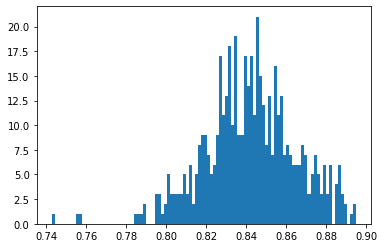

In [110]:
t = time.time()
ab_lrmse, ab_lr2 = run_cv(ab_model, N=500)
print('took %f seconds' % (time.time() - t))

ab_rmse = np.mean(ab_lrmse)
ab_r2 = np.mean(ab_lr2)

print('r2 %f (%f) rmse %f (%f)' % (ab_r2, np.std(ab_lr2), ab_rmse, np.std(ab_lrmse)))

In [113]:
parameters = {
    'n_estimators': [200,300,500],
    'learning_rate': [0.2, 0.4, 0.6, 0.8, 1.0]
}

t = time.time()
cv = KFold(n_splits=5, shuffle=True)
gs = GridSearchCV(GradientBoostingRegressor(), parameters, cv=cv, n_jobs=-1, scoring='r2')
gs.fit(X, y)
print('grid search %f sec' % (time.time() - t))

gb_model = gs.best_estimator_
print(model)

grid search 1.185134 sec
GradientBoostingRegressor(learning_rate=0.4, n_estimators=300)


In [114]:
t = time.time()
gb_lrmse, gb_lr2 = run_cv(gb_model, N=500)
print('took %f seconds' % (time.time() - t))

gb_rmse = np.mean(gb_lrmse)
gb_r2 = np.mean(gb_lr2)

print('r2 %f (%f) rmse %f (%f)' % (gb_r2, np.std(gb_lr2), gb_rmse, np.std(gb_lrmse)))

took 68.003886 seconds
r2 0.831249 (0.032072) rmse 0.382669 (0.026664)


In [160]:
svr_model = SVR(kernel='linear', C=0.1, epsilon=0.15)
svr_lrmse, svr_lr2 = run_cv(svr_model, N=500)
svr_rmse = np.mean(svr_lrmse)
svr_r2 = np.mean(svr_lr2)

print('r2 %f (%f) rmse %f (%f)' % (svr_r2, np.std(svr_lr2), svr_rmse, np.std(svr_lrmse)))

r2 0.845245 (0.018063) rmse 0.369296 (0.012092)


In [166]:
svrq_model = SVR(kernel='poly', coef0=5, C=0.1, epsilon=0.15, degree=2)
svrq_lrmse, svrq_lr2 = run_cv(svrq_model, N=500)
svrq_rmse = np.mean(svrq_lrmse)
svrq_r2 = np.mean(svrq_lr2)

print('r2 %f (%f) rmse %f (%f)' % (svrq_r2, np.std(svrq_lr2), svrq_rmse, np.std(svrq_lrmse)))

r2 0.865606 (0.017653) rmse 0.344321 (0.013407)


In [134]:
pca_model = make_pipeline(PCA(n_components=8), LinearRegression())
pca_lrmse, pca_lr2 = run_cv(pca_model, N=500)
pca_rmse = np.mean(pca_lrmse)
pca_r2 = np.mean(pca_lr2)

print('r2 %f (%f) rmse %f (%f)' % (pca_r2, np.std(pca_lr2), pca_rmse, np.std(pca_lrmse)))

r2 0.832337 (0.020803) rmse 0.384027 (0.015107)


In [138]:
ridge_model = Ridge(2.7)
ridge_lrmse, ridge_lr2 = run_cv(ridge_model, N=500)
ridge_rmse = np.mean(ridge_lrmse)
ridge_r2 = np.mean(ridge_lr2)

print('r2 %f (%f) rmse %f (%f)' % (ridge_r2, np.std(ridge_lr2), ridge_rmse, np.std(ridge_lrmse)))

r2 0.838628 (0.021327) rmse 0.376603 (0.013301)


In [143]:
rf_model = RandomForestRegressor(min_samples_leaf=3, n_estimators=400)
rf_lrmse, rf_lr2 = run_cv(ridge_model, N=500)
rf_rmse = np.mean(rf_lrmse)
rf_r2 = np.mean(rf_lr2)

print('r2 %f (%f) rmse %f (%f)' % (rf_r2, np.std(rf_lr2), rf_rmse, np.std(rf_lrmse)))

r2 0.838465 (0.018685) rmse 0.377268 (0.013248)


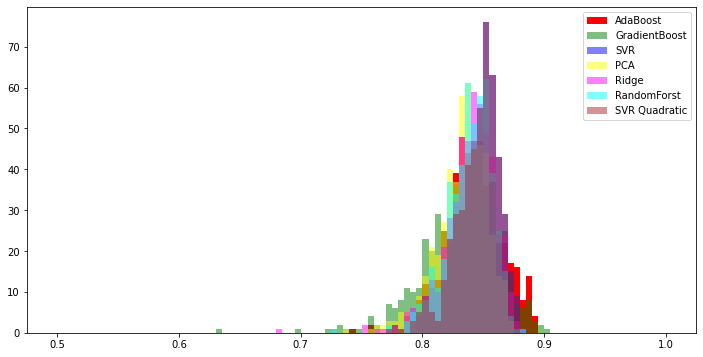

In [167]:
plt.figure(figsize=(12,6))
plt.hist(ab_lr2, bins=100, range=(0.5,1),label='AdaBoost',color='red')
plt.hist(gb_lr2, bins=100, range=(0.5,1),label='GradientBoost', color='green', alpha=0.5)
plt.hist(svr_lr2, bins=100, range=(0.5,1),label='SVR', color='blue', alpha=0.5)
plt.hist(pca_lr2, bins=100, range=(0.5,1),label='PCA', color='yellow', alpha=0.5)
plt.hist(ridge_lr2, bins=100, range=(0.5,1),label='Ridge', color='magenta', alpha=0.5)
plt.hist(rf_lr2, bins=100, range=(0.5,1),label='RandomForst', color='cyan', alpha=0.5)
plt.hist(svr_lr2, bins=100, range=(0.5,1),label='SVR Quadratic', color='brown', alpha=0.5)
plt.legend()
plt.show()

In [168]:
pd.DataFrame({
    'AdaBoost' : {
        'r2': np.mean(ab_lr2), 'rmse': np.mean(ab_lrmse),
        'std(r2)': np.std(ab_lr2), 'std(rmse)': np.std(ab_lrmse)
    },
    'GradientBoost' : {
        'r2': np.mean(gb_lr2), 'rmse': np.mean(gb_lrmse),
        'std(r2)': np.std(gb_lr2), 'std(rmse)': np.std(gb_lrmse)
    },
    'SVR' : {
        'r2': np.mean(svr_lr2), 'rmse': np.mean(svr_lrmse),
        'std(r2)': np.std(svr_lr2), 'std(rmse)': np.std(svr_lrmse)
    },
    'SVR (Quadratic)' : {
        'r2': np.mean(svrq_lr2), 'rmse': np.mean(svrq_lrmse),
        'std(r2)': np.std(svrq_lr2), 'std(rmse)': np.std(svrq_lrmse)
    },
    'PCA+LinearRegression' : {
        'r2': np.mean(pca_lr2), 'rmse': np.mean(pca_lrmse),
        'std(r2)': np.std(pca_lr2), 'std(rmse)': np.std(pca_lrmse)
    },
    'RidgeRegression' : {
        'r2': np.mean(ridge_lr2), 'rmse': np.mean(ridge_lrmse),
        'std(r2)': np.std(ridge_lr2), 'std(rmse)': np.std(ridge_lrmse)
    },
    'RandomForest' : {
        'r2': np.mean(rf_lr2), 'rmse': np.mean(rf_lrmse),
        'std(r2)': np.std(rf_lr2), 'std(rmse)': np.std(rf_lrmse)
    }
}).T.sort_values('r2', ascending=False)

,r2,rmse,std(r2),std(rmse)
SVR (Quadratic),0.865606,0.344321,0.017653,0.013407
SVR,0.845245,0.369296,0.018063,0.012092
AdaBoost,0.842094,0.374309,0.022872,0.020616
RidgeRegression,0.838628,0.376603,0.021327,0.013301
RandomForest,0.838465,0.377268,0.018685,0.013248
PCA+LinearRegression,0.832337,0.384027,0.020803,0.015107
GradientBoost,0.831249,0.382669,0.032072,0.026664
